In [5]:
import math
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
names = open('names.txt','r').read().splitlines()
chars = sorted(list(set((''.join(names)))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {stoi[s]: s for s in stoi}
vocab_size = len(stoi)

In [7]:
def train_dev_test_data(names, context_len=3, n=None):
    X, y = [], []
    for name in names[:n]:
        context = [0] * context_len
        for char in name + '.':
            i = stoi[char]
            X.append(context)
            y.append(i)
            if n is not None and n < 10:
                print(''.join(itos[j] for j in context), '->', itos[i])
            context = context[1:] + [i]
    
    zipped = list(zip(X, y))
    random.shuffle(zipped)
    X, y = zip(*zipped)
    
    n_dev = int(0.8 * len(X))
    n_test = int(0.9 * len(X))
    
    X_train = torch.tensor(X[:n_dev])
    y_train = torch.tensor(y[:n_dev])
    
    X_dev = torch.tensor(X[n_dev:n_test])
    y_dev = torch.tensor(y[n_dev:n_test])
    
    X_test = torch.tensor(X[n_test:])
    y_test = torch.tensor(y[n_test:])
    
    return X_train, y_train, X_dev, y_dev, X_test, y_test

# Making the code like PyTorch

In [35]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # <- gain
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

class BatchNorm1d:

    def __init__(self, fan_in, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(1, fan_in)
        self.beta = torch.zeros(1, fan_in)
        self.running_mean = torch.zeros(1, fan_in)
        self.running_var = torch.ones(1, fan_in)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var  = (1 - self.momentum) * self.running_var  + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out

    def parameters(self):
        return [self.weight]

class FlattenConsecutive:

    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        n = self.n
        x = x.view(B, T//n, C*n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def training_mode(self):
        for layer in self.layers:
            layer.training = True

    def inference_mode(self):
        for layer in self.layers:
            layer.training = False

In [36]:
# hyperparameters
dim_embed = 10
context_len = 8
n_hid = 68
softmax_scale = 0.01 # ensure softmax gives uniform distribution output
kaiming_init = (5 / 3) / ((dim_embed * context_len) ** 0.5) # gain to modify activation std and reduce tanh saturation
M = 0.001

# data and parameters
X_train, y_train, X_dev, y_dev, X_test, y_test = train_dev_test_data(names, context_len=context_len)

model = Sequential([
    Embedding(vocab_size, dim_embed),
    FlattenConsecutive(2), Linear(dim_embed * 2, n_hid, bias=False), BatchNorm1d(n_hid), Tanh(),
    FlattenConsecutive(2), Linear(    n_hid * 2, n_hid, bias=False), BatchNorm1d(n_hid), Tanh(),
    FlattenConsecutive(2), Linear(    n_hid * 2, n_hid, bias=False), BatchNorm1d(n_hid), Tanh(),
    Linear(n_hid, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # # ensure last layer -- logit layer -- feeding forward into softmax initially gives uniform distribution output to reduce loss
    for layer in model.layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

params = model.parameters()
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

22397


      0/ 200000: 3.1627
  10000/ 200000: 2.4278
  20000/ 200000: 2.3359
  30000/ 200000: 2.0927
  40000/ 200000: 2.0797
  50000/ 200000: 2.0411
  60000/ 200000: 2.1888
  70000/ 200000: 2.3386
  80000/ 200000: 1.8501
  90000/ 200000: 1.9376
 100000/ 200000: 1.9173
 110000/ 200000: 1.7378
 120000/ 200000: 1.9939
 130000/ 200000: 2.0064
 140000/ 200000: 1.8662
 150000/ 200000: 2.2461
 160000/ 200000: 2.1361
 170000/ 200000: 2.1156
 180000/ 200000: 1.7144
 190000/ 200000: 1.8761


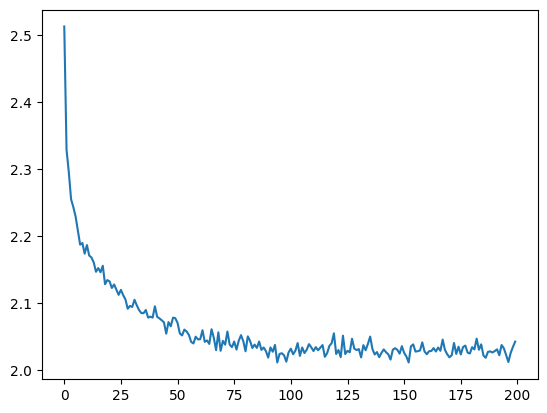

In [39]:
epochs = 200000
minibatch_sz = 32
lossi = []
updates = []
a = 0.1

for e in range(epochs):
    # minibatches
    rows = torch.randint(0, X_train.shape[0], (minibatch_sz, ))
    Xb, yb = X_train[rows], y_train[rows]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, yb)

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # stochastic gradient descent
    a = a if e < epochs / 2 else 0.1 * a
    for p in params:
        p.data -= a * p.grad

    lossi.append(loss.item())
    
    if e % 10000 == 0:
        print(f'{e:7d}/{epochs:7d}: {loss.item():.4f}')

    if e > epochs:
        break

plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [40]:
def compute_loss_torch(split):
    model.inference_mode()
    X, y = {
        'train': (X_train, y_train),
        'dev': (X_dev, y_dev),
        'test': (X_test, y_dev)
    }[split]
    logits = model(X)
    loss = F.cross_entropy(logits, y)
    model.training_mode()
    return loss

print(f'Training loss: {compute_loss_torch('train'):.4f}')
print(f'Dev loss: {compute_loss_torch('dev'):.4f}')

Training loss: 2.0055
Dev loss: 2.0747


In [42]:
def make_name_torch(k):
    model.inference_mode()
    g = torch.Generator().manual_seed(2147483647 + k)
    out = []
    context = [0] * context_len
    while True:
        logits = model(torch.tensor([context]))
        p = F.softmax(logits, dim=1)
        i = torch.multinomial(p, num_samples=1, generator=g).item()
        context = context[1:] + [i]
        out.append(i)
        if i == 0:
            break
    model.training_mode()
    return ''.join([itos[i] for i in out])

for k in range(10):
    print(make_name_torch(k))

junide.
camierho.
lakinn.
alianna.
jhala.
cari.
aannen.
kyrye.
raivan.
kelleentee.
